### Preparing the dataset
**Preparation:**

- Fill missing values with zeros.
- Do train/validation/test split with 60%/20%/20% distribution.
- Use the train_test_split function and set the random_state parameter to 1.
- Use DictVectorizer(sparse=True) to turn the dataframes into matrices.

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv'

In [3]:
!wget $data

--2025-11-03 12:07:31--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv’

car_fuel_efficiency 100%[===================>] 853.70K   790KB/s    in 1.1s    

2025-11-03 12:07:33 (790 KB/s) - ‘car_fuel_efficiency.csv’ saved [874188/874188]



In [6]:
# dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

In [7]:
df = pd.read_csv('car_fuel_efficiency.csv')

In [8]:
df.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217
2,170,NaN,78.0,3079.038997,15.1,2018,Europe,Gasoline,Front-wheel drive,0.0,14.246341
3,220,4.0,NaN,2542.392402,20.2,2009,USA,Diesel,All-wheel drive,2.0,16.912736
4,210,1.0,140.0,3460.870990,14.4,2009,Europe,Gasoline,All-wheel drive,2.0,12.488369


In [9]:
df.isnull().sum()

engine_displacement      0
num_cylinders          482
horsepower             708
vehicle_weight           0
acceleration           930
model_year               0
origin                   0
fuel_type                0
drivetrain               0
num_doors              502
fuel_efficiency_mpg      0
dtype: int64

In [10]:
# filling missing values with 0
df = df.fillna(0)

In [11]:
df.isnull().sum()

engine_displacement    0
num_cylinders          0
horsepower             0
vehicle_weight         0
acceleration           0
model_year             0
origin                 0
fuel_type              0
drivetrain             0
num_doors              0
fuel_efficiency_mpg    0
dtype: int64

In [19]:
df.dtypes

engine_displacement      int64
num_cylinders          float64
horsepower             float64
vehicle_weight         float64
acceleration           float64
model_year               int64
origin                  object
fuel_type               object
drivetrain              object
num_doors              float64
fuel_efficiency_mpg    float64
dtype: object

In [14]:
# Spliting the dataset with 60%/20%/20%
df_full_train,df_test = train_test_split(df,test_size=0.2,random_state=1)
df_train,df_val = train_test_split(df_full_train,test_size=0.25,random_state=1)

In [15]:
len(df_full_train),len(df_test),len(df_val),len(df_train)

(7763, 1941, 1941, 5822)

In [17]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

In [20]:
y_train = df_train.fuel_efficiency_mpg
y_test = df_test.fuel_efficiency_mpg
y_val = df_val.fuel_efficiency_mpg

In [22]:
df_train.fuel_efficiency_mpg

0       15.301475
1       15.331215
2       15.336679
3       15.865850
4       18.102203
          ...    
5817    12.798614
5818    14.945354
5819    15.188287
5820    17.396751
5821    16.160904
Name: fuel_efficiency_mpg, Length: 5822, dtype: float64

In [23]:
del df_train['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']

In [32]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

In [28]:
train_dicts = df_train.to_dict(orient='records')

In [50]:
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(train_dicts)

### Question 1
Let's train a decision tree regressor to predict the fuel_efficiency_mpg variable.

- Train a model with max_depth=1.


Which feature is used for splitting the data?

- 'vehicle_weight'
- 'model_year'
- 'origin'
- 'fuel_type'

In [51]:
dt = DecisionTreeRegressor(max_depth=1)

In [52]:
dt.fit(X_train,y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [66]:
features = dv.get_feature_names_out()
split_index = dt.tree_.feature[0]
split_threshold = dt.tree_.threshold[0]
print('The first split feature:', features[split_index])
print('The best split threshold:', split_threshold)

The first split feature: vehicle_weight
The best split threshold: 3022.1072998046875


In [56]:
# Another way to check the feature
def calculate_split_mse(X_train, y_train, feature_name, split_point):
    # Create DataFrame and sort by feature
    analysis_df = pd.DataFrame({
        'feature': X_train[feature_name],
        'y_actual': y_train
    }).sort_values('feature')

    # Split data and calculate means
    left_mask = analysis_df['feature'] <= split_point
    left_mean = analysis_df[left_mask]['y_actual'].mean()
    right_mean = analysis_df[~left_mask]['y_actual'].mean()

    # Calculate squared differences
    analysis_df['squared_diff'] = np.where(
        left_mask,
        (analysis_df['y_actual'] - left_mean) ** 2,
        (analysis_df['y_actual'] - right_mean) ** 2
    )

    # Calculate MSEs and counts
    left_mse = analysis_df[left_mask]['squared_diff'].mean()
    right_mse = analysis_df[~left_mask]['squared_diff'].mean()
    n_left = sum(left_mask)
    n_right = len(analysis_df) - n_left

    # Calculate weighted average MSE
    weighted_mse = (n_left * left_mse + n_right * right_mse) / len(analysis_df)

    # Print results
    print(analysis_df)
    print(f"nResults for split at {split_point} on feature '{feature_name}':")
    print(f"Left child MSE (n={n_left}, mean={left_mean:.2f}): {left_mse:.2f}")
    print(f"Right child MSE (n={n_right}, mean={right_mean:.2f}): {right_mse:.2f}")
    print(f"Weighted average MSE: {weighted_mse:.2f}")




In [67]:
X_train_df = pd.DataFrame(X_train.toarray(), columns=dv.get_feature_names_out())

for feature in features:
    calculate_split_mse(X_train_df, y_train, feature, 3022.11)

      feature   y_actual  squared_diff
901       0.0  17.551796      6.544347
4874      0.0  13.938586      1.113064
669       0.0  14.035475      0.918012
2841      0.0  12.776297      4.916450
680       0.0  11.245994     14.044583
...       ...        ...           ...
1042     22.7  10.103535     23.912775
5538     22.7  12.064896      8.577329
459      22.8  13.175784      3.304468
2935     23.4  10.320473     21.838152
3535     23.8  10.088860     24.056516

[5822 rows x 3 columns]
nResults for split at 3022.11 on feature 'acceleration':
Left child MSE (n=5822, mean=14.99): 6.40
Right child MSE (n=0, mean=nan): nan
Weighted average MSE: nan
      feature   y_actual  squared_diff
0         0.0  15.301475      0.094785
3253      0.0  19.596924     21.190559
3254      0.0  14.542749      0.203270
3255      0.0  16.089557      1.201113
3257      0.0  16.654215      2.757627
...       ...        ...           ...
1214      1.0  15.403845      0.168298
3420      1.0  17.142105      4.6

In [60]:
val_dicts = df_val.to_dict(orient='records')

In [61]:
X_val = dv.transform(val_dicts)

In [62]:
y_pred = dt.predict(X_val)

In [68]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
mae = mean_absolute_error(y_val,y_pred)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
mae,rmse

(1.284228674041171, np.float64(1.6104639028827592))

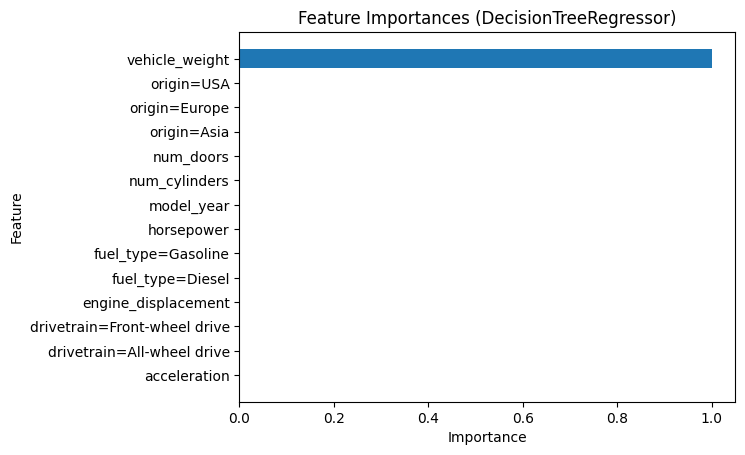

In [73]:
plt.barh(features, dt.feature_importances_)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances (DecisionTreeRegressor)")
plt.show()

### Question 2
Train a random forest regressor with these parameters:

- n_estimators=10
- random_state=1
- n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on the validation data?

- 0.045
- 0.45
- 4.5
- 45.0

In [69]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
rf = RandomForestRegressor(n_estimators=10,
                          random_state=1,
                          n_jobs=-1)

In [71]:
rf.fit(X_train,y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [72]:
y_pred = rf.predict(X_val)

In [74]:
rmse = np.sqrt(mean_squared_error(y_val,y_pred))

In [75]:
print('The RMSE of the Random Forest Regressor is: ', rmse)

The RMSE of the Random Forest Regressor is:  0.4586615458484906


### Question 3

Now let's experiment with the n_estimators parameter

- Try different values of this parameter from 10 to 200 with step 10.
- Set random_state to 1.
- Evaluate the model on the validation dataset.

After which value of n_estimators does RMSE stop improving? Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200
  
If it doesn't stop improving, use the latest iteration number in your answer.

In [80]:
rmse_scores = []
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n,
                          random_state=1,
                          n_jobs=-1)
    rf.fit(X_train,y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val,y_pred)).round(3)
    rmse_scores.append((n,rmse))

In [81]:
columns = ['n_estimator','rmse']
df_rmse_scores = pd.DataFrame(rmse_scores,columns=columns)
df_rmse_scores

,n_estimator,rmse
0,10,0.459
1,20,0.454
2,30,0.451
3,40,0.448
4,50,0.446
5,60,0.445
6,70,0.445
7,80,0.445
8,90,0.445
9,100,0.445


### Question 4

Let's select the best max_depth:

- Try different values of max_depth: [10, 15, 20, 25]
- For each of these values,
    - try different values of n_estimators from 10 till 200 (with step 10)
    - calculate the mean RMSE
- Fix the random seed: random_state=1

What's the best max_depth, using the mean RMSE?

- 10
- 15
- 20
- 25

In [88]:
rmse_scores = []

for m in [10, 15, 20, 25]:
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n,
                                   max_depth=m,
                                   random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train,y_train)
        y_pred = rf.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val,y_pred))
        rmse_scores.append((m,n,rmse))

In [89]:
columns = ['max_depth','n_estimator','rmse']
df_rmse_scores = pd.DataFrame(rmse_scores,columns=columns)
df_rmse_scores

,max_depth,n_estimator,rmse
0,10,10,0.450627
1,10,20,0.447109
2,10,30,0.445616
3,10,40,0.443237
4,10,50,0.442072
...,...,...,...
75,25,160,0.442814
76,25,170,0.442889
77,25,180,0.442600
78,25,190,0.442709


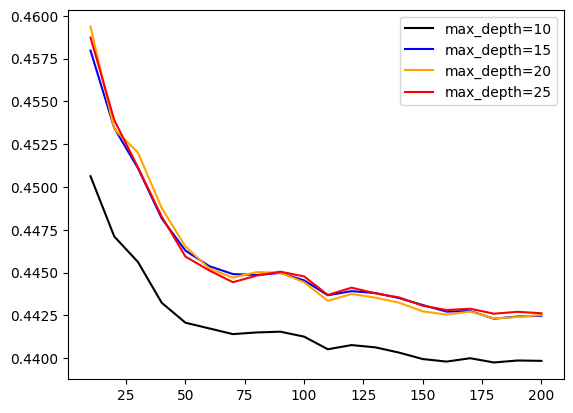

In [93]:
colors = ['black','blue','orange','red']
max_depth_values = [10, 15, 20, 25]
list(zip(max_depth_values,colors))


for s,col in zip(max_depth_values,colors):
    df_subset = df_rmse_scores[df_rmse_scores.max_depth ==s]
    plt.plot(df_subset.n_estimator,df_subset.rmse,
            label = 'max_depth=%d' % s,
            color=col)

    plt.legend()

In [117]:
print('The best max depth is %d with the lowest RMSE %s' % (10,df_rmse_scores[df_rmse_scores['max_depth']==10]['rmse'].mean()))

The best max depth is 10 with the lowest RMSE 0.4418792992525217


### Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorithm, it finds the best split. When doing it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

- Train the model with these parameters:
    - n_estimators=10,
    - max_depth=20,
    - random_state=1,
    - n_jobs=-1 (optional)
- Get the feature importance information from this model

What's the most important feature (among these 4)?

- vehicle_weight
- horsepower
- acceleration
- engine_displacement

In [118]:
rf = RandomForestRegressor(n_estimators=10,
                           max_depth=20,
                          random_state=1,
                          n_jobs=-1)

In [120]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val,y_pred))
rmse

np.float64(0.45937075026176954)

In [123]:
importances = rf.feature_importances_

In [124]:
df_importance = pd.DataFrame({
    'feature': features,
    'importance': importances
}).sort_values('importance', ascending=False)

In [125]:
df_importance.head()

,feature,importance
13,vehicle_weight,0.959153
6,horsepower,0.016066
0,acceleration,0.011490
3,engine_displacement,0.003279
7,model_year,0.003170


### Question 6

Now let's train an XGBoost model! For this question, we'll tune the eta parameter:

- Install XGBoost
- Create DMatrix for train and validation
- Create a watchlist
- Train a model with these parameters for 100 rounds:
```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change eta from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

- 0.3
- 0.1
- Both give equal value

In [127]:
import xgboost as xgb

In [128]:
features = dv.get_feature_names_out().tolist()
dtrain = xgb.DMatrix(X_train,label=y_train,feature_names = features)
dval = xgb.DMatrix(X_val,label=y_val,feature_names=features)

In [129]:
watchlist = [(dtrain,'train'),(dval,'val')]

In [150]:
%%capture output

xgb_params = {
    'eta':0.1,
    'max_depth':6,
    'min_child_weight':1,
    'objective':'reg:squarederror',
    'nthread':8,
    'seed':1,
    'verbosity':1,
    
}
model = xgb.train(xgb_params,dtrain,num_boost_round=100,
                  evals=watchlist)

In [145]:
def parse_xgb_output(output):
    results = []
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line,train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])


        results.append((it,train,val))

    columns = ['num_iter','train_auc','val_auc']
    df_results = pd.DataFrame(results,columns = columns)
    return df_results

In [146]:
scores = {}

In [151]:
df_score = parse_xgb_output(output)

In [152]:

key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.1'

In [153]:
scores.keys()

dict_keys(['eta=0.3', 'eta=0.1'])

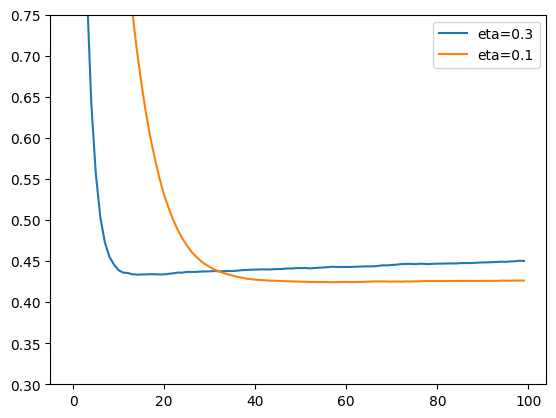

In [160]:
for key, df_score in scores.items():
    plt.plot(df_score.num_iter,df_score.val_auc,label=key)
plt.ylim(0.3,0.75)
plt.legend()

After 30 rounds, the value of eta=0.3 is less than the value of eta=0.1